In [1]:
import ast
import pathlib
import sys

import numpy as np
import pandas as pd
import toml
import torch
from sklearn import preprocessing

sys.path.append("../..")


import matplotlib.pyplot as plt
import seaborn as sns
from MLP_utils.parameters import Parameters
from MLP_utils.utils import (
    Dataset_formatter,
    output_stats,
    parameter_set,
    plot_metric_vs_epoch,
    results_output,
    test_optimized_model,
    train_optimized_model,
    un_nest,
)

sys.path.append("../../..")
import argparse

In [2]:
# # set up the parser
# parser = argparse.ArgumentParser(description="Train MLP model")

# # add arguments to parser
# parser.add_argument(
#     "--CELL_TYPE",
#     type=str,
#     default="all",
#     help="Cell type to train model on. Default is all",
# )

# parser.add_argument(
#     "--MODEL_NAME",
#     type=str,
#     default="MLP",
#     help="Model name to train. Default is MLP",
# )

# parser.add_argument(
#     "--SHUFFLE",
#     type=str,
#     default="False",
#     help="Shuffle data before training. Default is False",
# )

# # parse the arguments
# args = parser.parse_args()

# CELL_TYPE = args.CELL_TYPE
# MODEL_NAME = args.MODEL_NAME
# SHUFFLE = args.SHUFFLE
# SHUFFLE = ast.literal_eval(SHUFFLE)
# print(CELL_TYPE, MODEL_NAME, SHUFFLE)

In [3]:
CELL_TYPE = "SHSY5Y"
MODEL_NAME = "MultiClass_MLP"
SHUFFLE = False

In [4]:
ml_configs_file = pathlib.Path("../../MLP_utils/multi_class_config.toml").resolve(
    strict=True
)
ml_configs = toml.load(ml_configs_file)
params = Parameters()
mlp_params = parameter_set(params, ml_configs)

# overwrite params via command line arguments from papermill
mlp_params.CELL_TYPE = CELL_TYPE
mlp_params.MODEL_NAME = MODEL_NAME

mlp_params.MODEL_NAME = MODEL_NAME
mlp_params.SHUFFLE = SHUFFLE

# load in the class weights
class_weights_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/class_weights/{CELL_TYPE}/multi_class/class_weights.txt"
).resolve(strict=True)
# read the class weights into a list for use in the loss function as a list
class_weights = []
with open(class_weights_file_path, "r") as f:
    for line in f:
        class_weights.append(float(line.strip()))
# check the class weights are correct
print(class_weights)

[0.954878893196544, 0.4803479499984947, 0.5647731568049614]


In [5]:
# Import Data
# set data file path under pathlib path for multi-system use

file_path = pathlib.Path(
    f"../../../data/{mlp_params.CELL_TYPE}_preprocessed_sc_norm.parquet"
).resolve(strict=True)

df1 = pd.read_parquet(file_path)

In [6]:
# get paths for toml files
ground_truth_file_path = pathlib.Path(f"../../MLP_utils/ground_truth.toml").resolve(
    strict=True
)
treatment_splits_file_path = pathlib.Path(f"../../MLP_utils/splits.toml").resolve(
    strict=True
)
# read toml files
ground_truth = toml.load(ground_truth_file_path)
treatment_splits = toml.load(treatment_splits_file_path)

In [7]:
# get information from toml files
apoptosis_groups_list = ground_truth["Apoptosis"]["apoptosis_groups_list"]
pyroptosis_groups_list = ground_truth["Pyroptosis"]["pyroptosis_groups_list"]
healthy_groups_list = ground_truth["Healthy"]["healthy_groups_list"]

#### Set up Data to be compatible with model

##### Classification Models:
Comment out code if using regression

In [8]:
np.random.seed(0)
if ast.literal_eval(mlp_params.DATA_SUBSET_OPTION):
    df1 = df1.groupby("oneb_Metadata_Treatment_Dose_Inhibitor_Dose").apply(
        lambda x: x.sample(n=mlp_params.DATA_SUBSET_NUMBER, random_state=0)
    )
    print("Data Subset Is On")
    print(f"Data is subset to {mlp_params.DATA_SUBSET_NUMBER} per treatment group")
    print(df1.shape)
    df1.reset_index(drop=True, inplace=True)
else:
    print("Data Subset Is Off")

Data Subset Is Off


In [9]:
# add apoptosis, pyroptosis and healthy columns to dataframe
df1["apoptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in apoptosis_groups_list,
    axis=1,
)
df1["pyroptosis"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in pyroptosis_groups_list,
    axis=1,
)
df1["healthy"] = df1.apply(
    lambda row: row["oneb_Metadata_Treatment_Dose_Inhibitor_Dose"]
    in healthy_groups_list,
    axis=1,
)

# merge apoptosis, pyroptosis, and healthy columns into one column
df1["labels"] = df1.apply(
    lambda row: "apoptosis"
    if row["apoptosis"]
    else "pyroptosis"
    if row["pyroptosis"]
    else "healthy",
    axis=1,
)
# # drop apoptosis, pyroptosis, and healthy columns
df1.drop(columns=["apoptosis", "pyroptosis", "healthy"], inplace=True)

In [10]:
# set path for index file
index_file_path = pathlib.Path(
    f"../../0.hyperparameter_optimization/indexes/{params.CELL_TYPE}/multi_class/{params.MODEL_NAME}_data_split_indexes.tsv"
).resolve(strict=True)

# read index file
index_df = pd.read_csv(index_file_path, sep="\t")
index_df.head()

,labeled_data_index,label
0,490095,train
1,596097,train
2,374473,train
3,9193,train
4,222920,train


In [11]:
# get train, validation, test, and holdout indexes
train_indexes = index_df.loc[index_df["label"] == "train"]["labeled_data_index"]
val_indexes = index_df.loc[index_df["label"] == "val"]["labeled_data_index"]
test_indexes = index_df.loc[index_df["label"] == "test"]["labeled_data_index"]
treatment_holdout = index_df.loc[index_df["label"] == "treatment_holdout"][
    "labeled_data_index"
]
holdout_indexes = index_df.loc[index_df["label"] == "holdout"]["labeled_data_index"]
print(
    train_indexes.shape,
    val_indexes.shape,
    test_indexes.shape,
    treatment_holdout,
    holdout_indexes.shape,
)

assert (
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + treatment_holdout.shape[0]
    + holdout_indexes.shape[0]
) == index_df.shape[0]

(156696,) (39174,) (207575,) 403445     35856
403446     35857
403447     35858
403448     35859
403449     35860
           ...  
446996    587354
446997    587355
446998    587356
446999    587357
447000    587358
Name: labeled_data_index, Length: 43556, dtype: int64 (150901,)


In [12]:
treatment_holdout.head()

403445    35856
403446    35857
403447    35858
403448    35859
403449    35860
Name: labeled_data_index, dtype: int64

In [13]:
# Code snippet for metadata extraction by Jenna Tomkinson
df_metadata = list(df1.columns[df1.columns.str.startswith("Metadata")])

# define which columns are data and which are descriptive
df_descriptive = df1[df_metadata]
df_descriptive["labels"] = df1["labels"]
df_values = df1.drop(columns=df_metadata)

/tmp/ipykernel_728270/2522821119.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_descriptive["labels"] = df1["labels"]


In [14]:
# Creating label encoder
le = preprocessing.LabelEncoder()
# Converting strings into numbers
df_values["new_labels"] = le.fit_transform(df_values["labels"])
# get mini dataframe that contains the decoder
df_labels = df_values[["labels", "new_labels"]]
# split into X and Y where Y are the predictive column and x are the observable data
df_values_X = df_values.drop(
    [
        "oneb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "twob_Metadata_Treatment_Dose_Inhibitor_Dose",
        "threeb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "fourb_Metadata_Treatment_Dose_Inhibitor_Dose",
        "labels",
        "new_labels",
    ],
    axis=1,
)
df_values_Y = df_values["new_labels"]
df_values_Y.unique()
df_labels.drop_duplicates(inplace=True)
# pandas chaining to reset index and drop old index
df_labels.reset_index(drop=True, inplace=True)

/tmp/ipykernel_728270/2910622580.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels.drop_duplicates(inplace=True)


In [15]:
print(
    train_indexes.shape,
    val_indexes.shape,
    test_indexes.shape,
    treatment_holdout,
    holdout_indexes.shape,
)
print(
    train_indexes.shape[0]
    + val_indexes.shape[0]
    + test_indexes.shape[0]
    + treatment_holdout.shape[0]
    + holdout_indexes.shape[0]
)

(156696,) (39174,) (207575,) 403445     35856
403446     35857
403447     35858
403448     35859
403449     35860
           ...  
446996    587354
446997    587355
446998    587356
446999    587357
447000    587358
Name: labeled_data_index, Length: 43556, dtype: int64 (150901,)
597902


In [16]:
# get the train, validation, test, and holdout dataframes from the indexes
X_train = df_values_X.iloc[train_indexes.values]
X_val = df_values_X.iloc[val_indexes.values]
X_test = df_values_X.iloc[test_indexes.values]
X_treatment_holdout = df_values_X.iloc[treatment_holdout.values]
X_holdout = df_values_X.iloc[holdout_indexes.values]

Y_train = df_values_Y.iloc[train_indexes.values]
Y_val = df_values_Y.iloc[val_indexes.values]
Y_test = df_values_Y.iloc[test_indexes.values]
Y_treatment_holdout = df_values_Y.iloc[treatment_holdout.values]
Y_holdout = df_values_Y.iloc[holdout_indexes.values]

metadata_train = df_descriptive.iloc[train_indexes.values]
metadata_val = df_descriptive.iloc[val_indexes.values]
metadata_test = df_descriptive.iloc[test_indexes.values]
metadata_treatment_holdout = df_descriptive.iloc[treatment_holdout.values]
metadata_holdout = df_descriptive.iloc[holdout_indexes.values]

In [17]:
print(
    Y_train[Y_train == 0].shape,
    Y_train[Y_train == 1].shape,
    Y_train[Y_train == 2].shape,
)
print(Y_val[Y_val == 0].shape, Y_val[Y_val == 1].shape, Y_val[Y_val == 2].shape)
print(Y_test[Y_test == 0].shape, Y_test[Y_test == 1].shape, Y_test[Y_test == 2].shape)
print(
    Y_treatment_holdout[Y_treatment_holdout == 0].shape,
    Y_treatment_holdout[Y_treatment_holdout == 1].shape,
    Y_treatment_holdout[Y_treatment_holdout == 2].shape,
)
print(
    Y_holdout[Y_holdout == 0].shape,
    Y_holdout[Y_holdout == 1].shape,
    Y_holdout[Y_holdout == 2].shape,
)

(3946,) (89086,) (63664,)
(987,) (22272,) (15915,)
(4933,) (111361,) (91281,)
(10064,) (10941,) (22551,)
(7048,) (77041,) (66812,)


In [18]:
# reset indexes for all dataframes
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
X_treatment_holdout.reset_index(drop=True, inplace=True)
X_holdout.reset_index(drop=True, inplace=True)

Y_train.reset_index(drop=True, inplace=True)
Y_val.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
Y_treatment_holdout.reset_index(drop=True, inplace=True)
Y_holdout.reset_index(drop=True, inplace=True)

In [19]:
print(
    X_train.shape, X_val.shape, X_test.shape, X_treatment_holdout.shape, X_holdout.shape
)
print(
    Y_train.shape, Y_val.shape, Y_test.shape, Y_treatment_holdout.shape, Y_holdout.shape
)

(156696, 1251) (39174, 1251) (207575, 1251) (43556, 1251) (150901, 1251)
(156696,) (39174,) (207575,) (43556,) (150901,)


#### Shuffle Data


In [20]:
np.random.seed(0)

if SHUFFLE:
    print("Shuffling Data")
    for column in X_train.columns:
        X_train[column] = np.random.permutation(X_train[column].values)

#### Split Data - All Models can proceed through this point

In [21]:
# produce data objects for train, val and test datasets
train_data = Dataset_formatter(
    torch.FloatTensor(X_train.values), torch.FloatTensor(Y_train.values)
)
val_data = Dataset_formatter(
    torch.FloatTensor(X_val.values), torch.FloatTensor(Y_val.values)
)
test_data = Dataset_formatter(
    torch.FloatTensor(X_test.values), torch.FloatTensor(Y_test.values)
)

In [22]:
mlp_params.IN_FEATURES = X_train.shape[1]
print("Number of in features: ", mlp_params.IN_FEATURES)
if mlp_params.MODEL_TYPE == "Regression":
    mlp_params.OUT_FEATURES = 1
else:
    mlp_params.OUT_FEATURES = len(df_values["labels"].unique())

print("Number of out features: ", mlp_params.OUT_FEATURES)

if mlp_params.OUT_FEATURES > 2:
    mlp_params.MODEL_TYPE = "Multi_Class"
elif mlp_params.OUT_FEATURES == 2:
    mlp_params.OUT_FEATURES = mlp_params.OUT_FEATURES - 1
    mlp_params.MODEL_TYPE = "Binary_Classification"
elif mlp_params.OUT_FEATURES == 1:
    mlp_params.MODEL_TYPE = "Regression"
else:
    pass
print(mlp_params.MODEL_TYPE)

Number of in features:  1251
Number of out features:  3
Multi_Class


In [23]:
# convert data class into a dataloader to be compatible with pytorch
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=mlp_params.BATCH_SIZE, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=mlp_params.BATCH_SIZE, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=1, shuffle=False
)

In [24]:
# call the optimized training model
train_loss, train_acc, valid_loss, valid_acc, epochs_ran, model = train_optimized_model(
    mlp_params.TRAIN_EPOCHS,
    train_loader,
    valid_loader,
    params,
    mlp_params.MODEL_NAME,
    mlp_params.SHUFFLE,
    class_weights=class_weights,
)
# get training_metrics
if mlp_params.MODEL_TYPE == "Regression":
    training_stats = pd.DataFrame(
        zip(train_loss, valid_loss, epochs_ran),
        columns=["train_loss", "valid_loss", "epochs_ran"],
    )
else:
    training_stats = pd.DataFrame(
        zip(train_loss, train_acc, valid_loss, valid_acc, epochs_ran),
        columns=["train_loss", "train_acc", "valid_loss", "valid_acc", "epochs_ran"],
    )

SGD
Epoch 0: Validation loss decreased (inf --> 0.573896).  Saving model ...
	 Train_Loss: 0.6088 Train_Acc: 70.833 Val_Loss: 0.5739  BEST VAL Loss: 0.5739  Val_Acc: 71.734

Epoch 1: Validation loss decreased (0.573896 --> 0.556676).  Saving model ...
	 Train_Loss: 0.5854 Train_Acc: 72.939 Val_Loss: 0.5567  BEST VAL Loss: 0.5567  Val_Acc: 74.072

Epoch 2: Validation loss decreased (0.556676 --> 0.551536).  Saving model ...
	 Train_Loss: 0.5712 Train_Acc: 73.836 Val_Loss: 0.5515  BEST VAL Loss: 0.5515  Val_Acc: 73.158

Epoch 3: Validation loss decreased (0.551536 --> 0.548786).  Saving model ...
	 Train_Loss: 0.5613 Train_Acc: 74.348 Val_Loss: 0.5488  BEST VAL Loss: 0.5488  Val_Acc: 73.133

Epoch 4: Validation loss decreased (0.548786 --> 0.545996).  Saving model ...
	 Train_Loss: 0.5533 Train_Acc: 74.832 Val_Loss: 0.5460  BEST VAL Loss: 0.5460  Val_Acc: 74.917

Epoch 5: Validation loss decreased (0.545996 --> 0.543186).  Saving model ...
	 Train_Loss: 0.5461 Train_Acc: 75.329 Val_Loss:

In [25]:
# create a dataframe to store the model stats
model_stats_df = pd.DataFrame(
    columns=[
        "label",
        "metric",
        "value",
        "group",
        "shuffled_data",
    ]
)
# check empty dataframe
model_stats_df

,label,metric,value,group,shuffled_data


/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1015: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1016: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


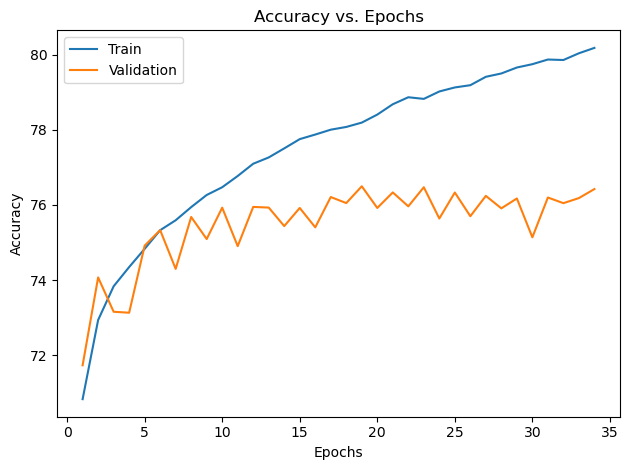

In [26]:
if mlp_params.MODEL_TYPE == "Regression":
    pass
else:
    plot_metric_vs_epoch(
        training_stats,
        x="epochs_ran",
        y1="train_acc",
        y2="valid_acc",
        title="Accuracy vs. Epochs",
        x_axis_label="Epochs",
        y_axis_label="Accuracy",
        params=params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )

/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1015: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y1], palette="blue", label="Train")
/home/lippincm/Documents/ML/Interstellar_Analysis/4.sc_Morphology_Neural_Network_MLP_Model/1.model_training/notebooks/../../MLP_utils/utils.py:1016: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=df[x], y=df[y2], palette="orange", label="Validation")


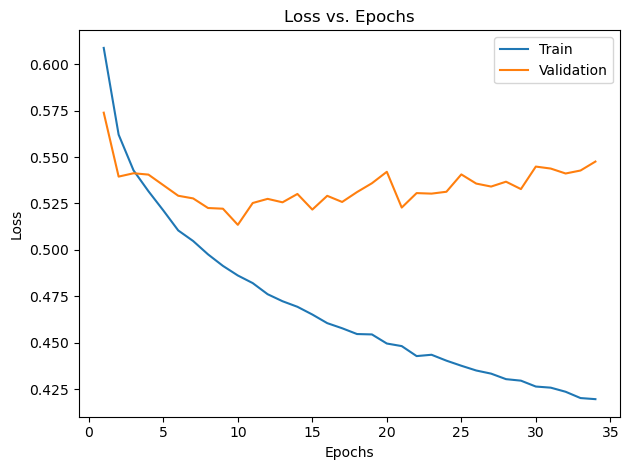

In [27]:
plot_metric_vs_epoch(
    training_stats,
    x="epochs_ran",
    y1="train_loss",
    y2="valid_loss",
    title="Loss vs. Epochs",
    x_axis_label="Epochs",
    y_axis_label="Loss",
    params=params,
    model_name=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)

### Test Models on training data

In [28]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        train_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


In [29]:
stats_df = output_stats(
    y_pred_list,
    Y_train,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.03      0.03      0.03      3946
           1       0.57      0.60      0.58     89086
           2       0.41      0.38      0.39     63664

    accuracy                           0.49    156696
   macro avg       0.33      0.33      0.33    156696
weighted avg       0.49      0.49      0.49    156696



/tmp/ipykernel_728270/3128628192.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [30]:
stats_df["group"] = "train"
stats_df["shuffled_data"] = mlp_params.SHUFFLE
stats_df
model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

### Test models on Validation data

In [31]:
# test the model on training data
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        valid_loader,
        mlp_params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


In [32]:
stats_df = output_stats(
    y_pred_list,
    Y_val,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       987
           1       0.78      0.82      0.80     22272
           2       0.73      0.67      0.70     15915

    accuracy                           0.76     39174
   macro avg       0.77      0.76      0.77     39174
weighted avg       0.76      0.76      0.76     39174



/tmp/ipykernel_728270/3927671392.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [33]:
stats_df["group"] = "validation"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_728270/1023299338.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


In [34]:
mlp_params.MODEL_NAME

'MultiClass_MLP'

### Testing on the test data

In [35]:
# create a dataframe to store the model confusion matrix
data_split_conf_mat_df_all = pd.DataFrame(
    columns=["True_Label", "Predicted_Label", "Count", "data_split", "Recall"]
)

In [36]:
# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        test_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")


# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_test):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

MultiClass_MLP


              precision    recall  f1-score   support

           0       0.77      0.78      0.77      4933
           1       0.74      0.82      0.78    111361
           2       0.75      0.66      0.70     91281

    accuracy                           0.75    207575
   macro avg       0.76      0.75      0.75    207575
weighted avg       0.75      0.75      0.75    207575

Precision for class 0: 0.7736001617141702
Recall for class 0: 0.7757956618690452
Precision for class 1: 0.7429419176523189
Recall for class 1: 0.8206912653442408
Precision for class 2: 0.753168452388429
Recall for class 2: 0.6568946440113496
3


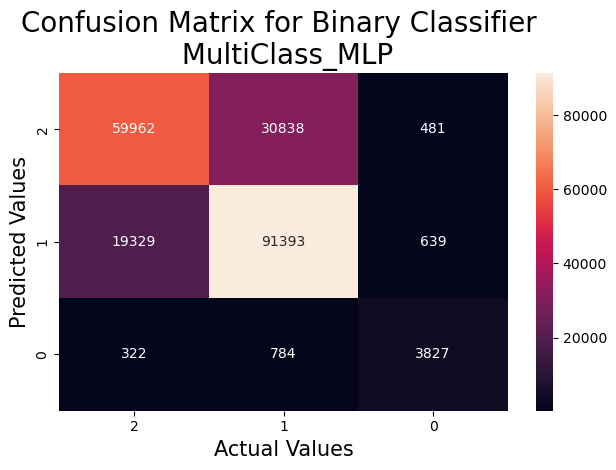

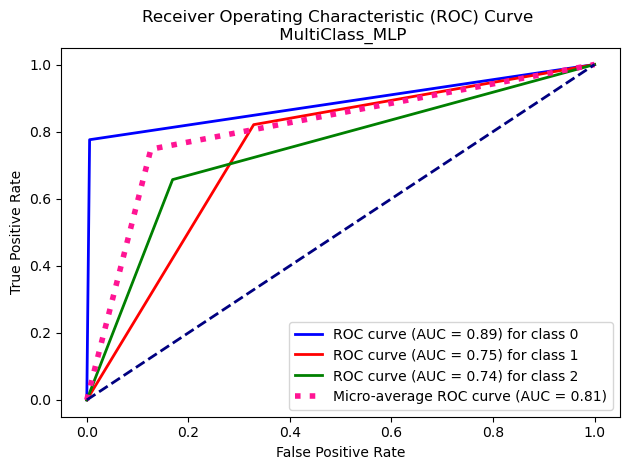

In [37]:
# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_test,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_test,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_testing",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [38]:
# define a final dataframe to store the predictions
final_predictions_df = pd.DataFrame()

In [39]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_test], axis=1)
y_pred_df = pd.concat([y_pred_df, X_test], axis=1)

In [40]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_test.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_test], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [41]:
y_pred_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_inducer2_concentration_unit,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels
index,,,,,,,,,,,,,,,,,,,,,
3,1,1,-0.170167,0.629520,-0.073836,-0.157516,0.293237,-0.120336,1.719615,-0.246840,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,4,4,6,6,media_ctr,0.0_None,healthy
4,1,1,0.768220,0.449374,-1.428445,-0.917133,-0.872718,-1.004087,1.062510,-1.173193,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,5,5,7,7,media_ctr,0.0_None,healthy
5,1,1,0.302347,0.890920,-0.850050,-0.601106,-0.083083,-0.866272,-0.914505,-0.676300,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,6,6,8,8,media_ctr,0.0_None,healthy
6,1,1,0.446028,0.965526,-0.711945,-0.708833,1.346422,0.084637,0.303813,-1.016917,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy
7,2,1,-0.316498,0.336804,-0.813935,0.016854,0.303227,0.310584,-0.867611,0.012472,...,None,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597891,1,1,-0.531397,1.324286,-0.974859,0.317338,0.310480,-1.574190,-0.988383,-0.847911,...,None,1245,*70117_20230210MM1_Gasdermin514_CP_BC430856,85,85,92,92,media_ctr,0.0_None,healthy
597892,1,1,-0.456181,-0.221158,-0.112183,0.205360,-1.104375,-0.732321,1.104257,0.227782,...,None,1245,*70117_20230210MM1_Gasdermin514_CP_BC430856,89,89,96,96,media_ctr,0.0_None,healthy
597894,1,1,-0.613186,0.894586,-0.108806,0.448655,1.547998,0.420977,1.046028,-0.604050,...,None,1245,*70117_20230210MM1_Gasdermin514_CP_BC430856,114,114,123,123,media_ctr,0.0_None,healthy


In [42]:
y_pred_df["data_split"] = "test"

In [43]:
# save the y_pred_df to a parquet file if shuffle is set to False
if not SHUFFLE:
    # set path
    y_pred_df_path = pathlib.Path(
        f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/testing_single_cell_predictions.parquet"
    )
    # make path if it doesn't exist
    y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
    # save the dataframe
    y_pred_df.to_parquet(y_pred_df_path)

In [44]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
3,1,1,-0.170167,0.629520,-0.073836,-0.157516,0.293237,-0.120336,1.719615,-0.246840,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,4,4,6,6,media_ctr,0.0_None,healthy,test
4,1,1,0.768220,0.449374,-1.428445,-0.917133,-0.872718,-1.004087,1.062510,-1.173193,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,5,5,7,7,media_ctr,0.0_None,healthy,test
5,1,1,0.302347,0.890920,-0.850050,-0.601106,-0.083083,-0.866272,-0.914505,-0.676300,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,6,6,8,8,media_ctr,0.0_None,healthy,test
6,1,1,0.446028,0.965526,-0.711945,-0.708833,1.346422,0.084637,0.303813,-1.016917,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy,test
7,2,1,-0.316498,0.336804,-0.813935,0.016854,0.303227,0.310584,-0.867611,0.012472,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597891,1,1,-0.531397,1.324286,-0.974859,0.317338,0.310480,-1.574190,-0.988383,-0.847911,...,1245,*70117_20230210MM1_Gasdermin514_CP_BC430856,85,85,92,92,media_ctr,0.0_None,healthy,test
597892,1,1,-0.456181,-0.221158,-0.112183,0.205360,-1.104375,-0.732321,1.104257,0.227782,...,1245,*70117_20230210MM1_Gasdermin514_CP_BC430856,89,89,96,96,media_ctr,0.0_None,healthy,test
597894,1,1,-0.613186,0.894586,-0.108806,0.448655,1.547998,0.420977,1.046028,-0.604050,...,1245,*70117_20230210MM1_Gasdermin514_CP_BC430856,114,114,123,123,media_ctr,0.0_None,healthy,test


In [45]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [46]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "testing"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [47]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [48]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "testing"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

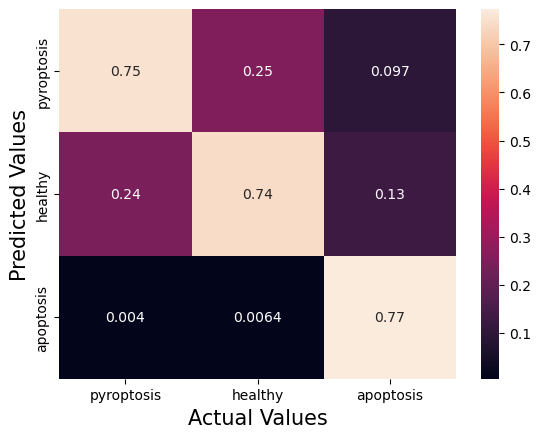

In [49]:
ax = sns.heatmap(confusion_matrix_df, annot=True)
ax.invert_xaxis()
ax.invert_yaxis()
plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [50]:
stats_df = output_stats(
    y_pred_list,
    Y_test,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.77      0.78      0.77      4933
           1       0.74      0.82      0.78    111361
           2       0.75      0.66      0.70     91281

    accuracy                           0.75    207575
   macro avg       0.76      0.75      0.75    207575
weighted avg       0.75      0.75      0.75    207575



/tmp/ipykernel_728270/832989993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [51]:
stats_df["group"] = "test"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)

/tmp/ipykernel_728270/3610522228.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


## Test the treatment holdout data on the model

MultiClass_MLP
              precision    recall  f1-score   support

           0       0.96      0.42      0.58     10064
           1       0.37      0.68      0.48     10941
           2       0.75      0.63      0.68     22551

    accuracy                           0.59     43556
   macro avg       0.69      0.58      0.58     43556
weighted avg       0.70      0.59      0.61     43556

Precision for class 0: 0.9567000911577028
Recall for class 0: 0.4171303656597774
Precision for class 1: 0.3673932340467502
Recall for class 1: 0.6809249611552874
Precision for class 2: 0.7492323980942297
Recall for class 2: 0.6275996629861204
3


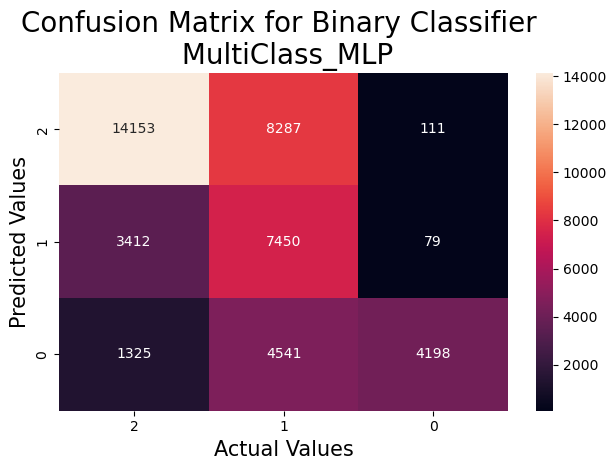

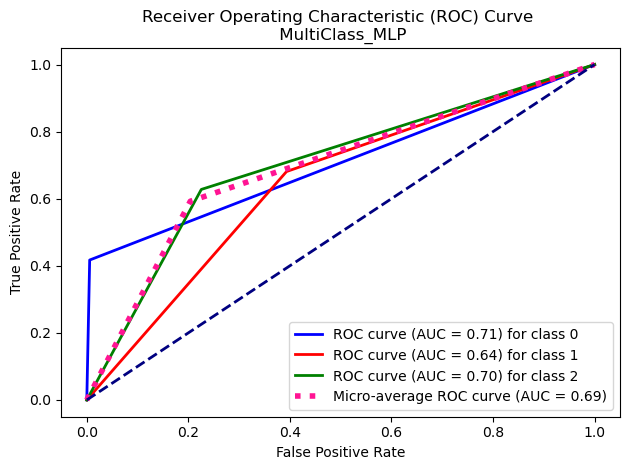

In [52]:
treatment_holdout_data = Dataset_formatter(
    torch.FloatTensor(X_treatment_holdout.values),
    torch.FloatTensor(Y_treatment_holdout.values),
)

# convert data class into a dataloader to be compatible with pytorch
treatment_holdout_loader = torch.utils.data.DataLoader(
    dataset=treatment_holdout_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        treatment_holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        treatment_holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_treatment_holdout):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_treatment_holdout,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_treatment_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_treatment_holdout,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_treatment_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [53]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_treatment_holdout], axis=1)
y_pred_df = pd.concat([y_pred_df, X_treatment_holdout], axis=1)

In [54]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_treatment_holdout.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_treatment_holdout], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [55]:
y_pred_df["data_split"] = "treatment_holdout"

In [56]:
# save the y_pred_df to a parquet file
if not SHUFFLE:
    # set path
    y_pred_df_path = pathlib.Path(
        f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/treatment_holdout_single_cell_predictions.parquet"
    )
    # make path if it doesn't exist
    y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
    # save the dataframe
    y_pred_df.to_parquet(y_pred_df_path)

In [57]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
3,1,1,-0.170167,0.629520,-0.073836,-0.157516,0.293237,-0.120336,1.719615,-0.246840,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,4,4,6,6,media_ctr,0.0_None,healthy,test
4,1,1,0.768220,0.449374,-1.428445,-0.917133,-0.872718,-1.004087,1.062510,-1.173193,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,5,5,7,7,media_ctr,0.0_None,healthy,test
5,1,1,0.302347,0.890920,-0.850050,-0.601106,-0.083083,-0.866272,-0.914505,-0.676300,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,6,6,8,8,media_ctr,0.0_None,healthy,test
6,1,1,0.446028,0.965526,-0.711945,-0.708833,1.346422,0.084637,0.303813,-1.016917,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy,test
7,2,1,-0.316498,0.336804,-0.813935,0.016854,0.303227,0.310584,-0.867611,0.012472,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587354,1,1,-0.779527,1.032518,1.141343,0.751842,0.748608,-0.522054,-1.364066,0.531731,...,718,*70117_20230210MM1_Gasdermin514_CP_BC430856,237,237,258,258,Flagellin,0.100_µg_per_ml,healthy,treatment_holdout
587355,1,1,0.510354,0.717275,-0.651775,-0.753853,1.216464,0.548330,1.216662,-1.218646,...,718,*70117_20230210MM1_Gasdermin514_CP_BC430856,238,238,259,259,Flagellin,0.100_µg_per_ml,healthy,treatment_holdout
587356,2,1,0.846230,1.120218,-1.576776,-0.961735,-0.016906,-1.250561,0.527545,-1.300190,...,718,*70117_20230210MM1_Gasdermin514_CP_BC430856,239,239,260,260,Flagellin,0.100_µg_per_ml,healthy,treatment_holdout


In [58]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
# rename index from the decoder dictionary
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [59]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "treatment_holdout"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [60]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [61]:
# change the order of the columns
confusion_matrix_df = confusion_matrix_df[["healthy", "apoptosis", "pyroptosis"]]
# change the order of the index
confusion_matrix_df = confusion_matrix_df.reindex(
    index=["healthy", "apoptosis", "pyroptosis"]
)

In [62]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "treatment_holdout"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

/tmp/ipykernel_728270/3256508403.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data_split_conf_mat_df_all = pd.concat(


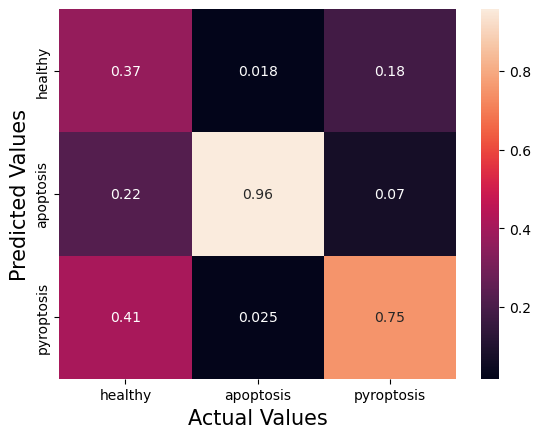

In [63]:
ax = sns.heatmap(confusion_matrix_df, annot=True)

plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [64]:
stats_df = output_stats(
    y_pred_list,
    Y_treatment_holdout,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.96      0.42      0.58     10064
           1       0.37      0.68      0.48     10941
           2       0.75      0.63      0.68     22551

    accuracy                           0.59     43556
   macro avg       0.69      0.58      0.58     43556
weighted avg       0.70      0.59      0.61     43556



/tmp/ipykernel_728270/2595163325.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [65]:
stats_df["group"] = "treatment_holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)
model_stats_df

/tmp/ipykernel_728270/819937216.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


,label,metric,value,group,shuffled_data
0,apoptosis,precision,0.027982,train,False
1,healthy,precision,0.568947,train,False
2,pyroptosis,precision,0.407116,train,False
3,accuracy,accuracy,0.494301,train,False
4,macro avg,precision,0.334682,train,False
...,...,...,...,...,...
19,healthy,support,10941.000000,treatment_holdout,False
20,pyroptosis,support,22551.000000,treatment_holdout,False
21,accuracy,accuracy,0.592364,treatment_holdout,False
22,macro avg,support,43556.000000,treatment_holdout,False


## Test the hold out wells

MultiClass_MLP
              precision    recall  f1-score   support

           0       0.86      0.58      0.69      7048
           1       0.73      0.81      0.77     77041
           2       0.75      0.68      0.71     66812

    accuracy                           0.74    150901
   macro avg       0.78      0.69      0.72    150901
weighted avg       0.74      0.74      0.74    150901

Precision for class 0: 0.8632424434580428
Recall for class 0: 0.5794551645856981
Precision for class 1: 0.7253094639817506
Recall for class 1: 0.8130346179307122
Precision for class 2: 0.7546939526174116
Recall for class 2: 0.6756121654792552
3


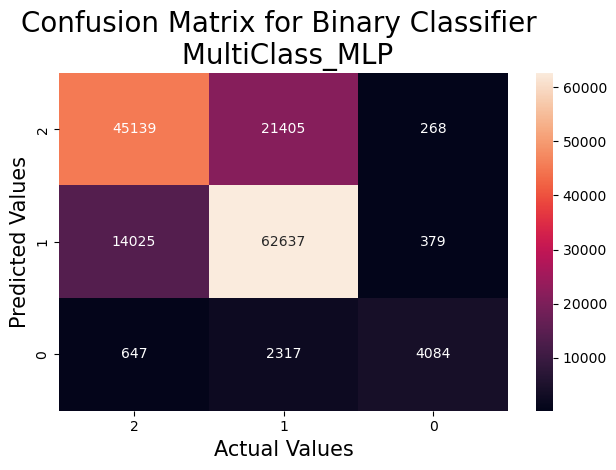

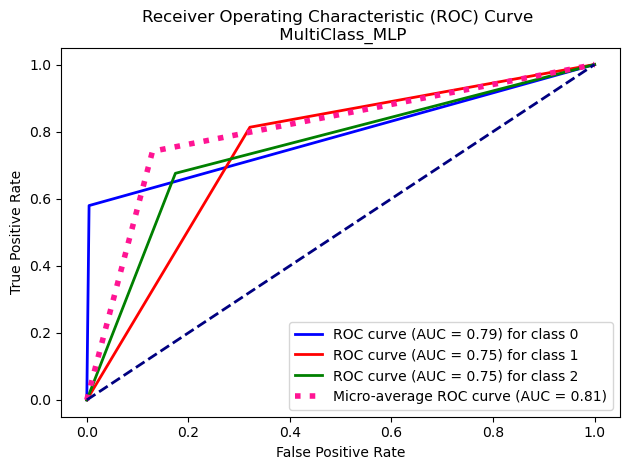

In [66]:
holdout_data = Dataset_formatter(
    torch.FloatTensor(X_holdout.values), torch.FloatTensor(Y_holdout.values)
)

# convert data class into a dataloader to be compatible with pytorch
holdout_loader = torch.utils.data.DataLoader(
    dataset=holdout_data, batch_size=1, shuffle=mlp_params.SHUFFLE
)

# calling the testing function and outputting list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    y_pred_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    y_pred_list, y_pred_prob_list = test_optimized_model(
        model,
        holdout_loader,
        params,
        model_name=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

# un-nest list if nested i.e. length of input data does not match length of output data
if len(y_pred_list) != len(Y_holdout):
    y_pred_list = un_nest(y_pred_list)
    if mlp_params.MODEL_TYPE == "Binary_Classification":
        y_pred_prob_list = un_nest(y_pred_prob_list)
else:
    pass

# Call visualization function
# calling the testing function and outputing list values of tested model
if any(
    model_type == mlp_params.MODEL_TYPE for model_type in ["Multi_Class", "Regression"]
):
    confusion_matrix_df = results_output(
        y_pred_list,
        Y_holdout,
        params,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
elif mlp_params.MODEL_TYPE == "Binary_Classification":
    results_output(
        y_pred_list,
        Y_holdout,
        params,
        y_pred_prob_list,
        test_name=f"{mlp_params.MODEL_NAME}_hold_out",
        model_name=mlp_params.MODEL_NAME,
        title=mlp_params.MODEL_NAME,
        shuffle=mlp_params.SHUFFLE,
    )
else:
    raise Exception("Model type must be specified for proper model testing")

In [67]:
# merge the y_pred_list and Y_holdout into a dataframe
y_pred_df = pd.DataFrame(y_pred_list, columns=["y_pred"])
y_pred_df = pd.concat([y_pred_df, Y_holdout], axis=1)
y_pred_df = pd.concat([y_pred_df, X_holdout], axis=1)

In [68]:
# merge y_pred_df with metadata_holdout whiile keeping the index of metadata_holdout
metadata_holdout.reset_index(inplace=True)
y_pred_df = pd.concat([y_pred_df, metadata_holdout], axis=1)
# set the index to the index column
y_pred_df.set_index("index", inplace=True, drop=True)

In [69]:
y_pred_df["data_split"] = "holdout"

In [70]:
# save the y_pred_df to a parquet file
if not SHUFFLE:
    # set path
    y_pred_df_path = pathlib.Path(
        f"../../results/Multi_Class/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}/holdout_single_cell_predictions.parquet"
    )
    # make path if it doesn't exist
    y_pred_df_path.parent.mkdir(parents=True, exist_ok=True)
    # save the dataframe
    y_pred_df.to_parquet(y_pred_df_path)

In [71]:
final_predictions_df = pd.concat([final_predictions_df, y_pred_df], axis=0)
final_predictions_df

,y_pred,new_labels,Cytoplasm_AreaShape_Compactness,Cytoplasm_AreaShape_Eccentricity,Cytoplasm_AreaShape_Extent,Cytoplasm_AreaShape_FormFactor,Cytoplasm_AreaShape_MajorAxisLength,Cytoplasm_AreaShape_MinorAxisLength,Cytoplasm_AreaShape_Orientation,Cytoplasm_AreaShape_Zernike_0_0,...,Metadata_ImageNumber,Metadata_Plate,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Treatment,Metadata_Dose,labels,data_split
index,,,,,,,,,,,,,,,,,,,,,
3,1,1,-0.170167,0.629520,-0.073836,-0.157516,0.293237,-0.120336,1.719615,-0.246840,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,4,4,6,6,media_ctr,0.0_None,healthy,test
4,1,1,0.768220,0.449374,-1.428445,-0.917133,-0.872718,-1.004087,1.062510,-1.173193,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,5,5,7,7,media_ctr,0.0_None,healthy,test
5,1,1,0.302347,0.890920,-0.850050,-0.601106,-0.083083,-0.866272,-0.914505,-0.676300,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,6,6,8,8,media_ctr,0.0_None,healthy,test
6,1,1,0.446028,0.965526,-0.711945,-0.708833,1.346422,0.084637,0.303813,-1.016917,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,7,7,9,9,media_ctr,0.0_None,healthy,test
7,2,1,-0.316498,0.336804,-0.813935,0.016854,0.303227,0.310584,-0.867611,0.012472,...,1,*70117_20230210MM1_Gasdermin514_CP_BC430856,8,8,10,10,media_ctr,0.0_None,healthy,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584185,1,1,-0.148761,0.604165,-0.161017,-0.181287,-0.245968,-0.580142,0.390559,-0.674253,...,541,*70117_20230210MM1_Gasdermin514_CP_BC430856,185,185,188,188,H2O2,100.000_µM,healthy,holdout
584186,1,1,0.118484,-0.516577,-0.181496,-0.446729,-0.302140,0.471772,-1.470387,0.593381,...,542,*70117_20230210MM1_Gasdermin514_CP_BC430856,2,2,7,7,H2O2,100.000_µM,healthy,holdout
584187,1,1,-0.644262,-0.679431,-0.374136,0.501408,-0.463848,0.378950,0.245302,0.249623,...,542,*70117_20230210MM1_Gasdermin514_CP_BC430856,129,129,141,141,H2O2,100.000_µM,healthy,holdout


In [72]:
# rename columns from the decoder dictionary
confusion_matrix_df.rename(
    columns={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)
# rename index from the decoder dictionary
confusion_matrix_df.rename(
    index={0: "apoptosis", 1: "healthy", 2: "pyroptosis"}, inplace=True
)

In [73]:
confusion_matrices = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices = pd.melt(
    confusion_matrices,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices["data_split"] = "holdout"
# sum of the columns of the confusion matrix gives the total number of samples per class
sum_of_columns = confusion_matrix_df.sum(axis=0)

In [74]:
# normalize confusion matrix
# get the sum of each column to normalize the confusion matrix by the total number of samples per class

# divide the apotosis column by the sum of the apotosis column
confusion_matrix_df["apoptosis"] = confusion_matrix_df["apoptosis"] / sum_of_columns[0]
# divide the healthy column by the sum of the healthy column
confusion_matrix_df["healthy"] = confusion_matrix_df["healthy"] / sum_of_columns[1]
# divide the pyroptosis column by the sum of the pyroptosis column
confusion_matrix_df["pyroptosis"] = (
    confusion_matrix_df["pyroptosis"] / sum_of_columns[2]
)

In [75]:
# change the order of the columns
confusion_matrix_df = confusion_matrix_df[["healthy", "apoptosis", "pyroptosis"]]
# change the order of the index
confusion_matrix_df = confusion_matrix_df.reindex(
    index=["healthy", "apoptosis", "pyroptosis"]
)

In [76]:
confusion_matrices_recall = confusion_matrix_df.reset_index()
# melt the DataFrame to a long format
confusion_matrices_recall = pd.melt(
    confusion_matrices_recall,
    id_vars=["index"],
    value_vars=["healthy", "apoptosis", "pyroptosis"],
)

# rename the columns
confusion_matrices_recall.columns = ["True_Label", "Predicted_Label", "Count"]
confusion_matrices_recall["data_split"] = "holdout"
confusion_matrices_recall.rename(columns={"Count": "Recall"}, inplace=True)
data_split_conf_mat_df = pd.merge(
    confusion_matrices,
    confusion_matrices_recall,
    on=["True_Label", "Predicted_Label", "data_split"],
)
data_split_conf_mat_df["shuffled_data"] = mlp_params.SHUFFLE
data_split_conf_mat_df_all = pd.concat(
    [data_split_conf_mat_df_all, data_split_conf_mat_df], axis=0
)

/tmp/ipykernel_728270/2372900873.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  data_split_conf_mat_df_all = pd.concat(


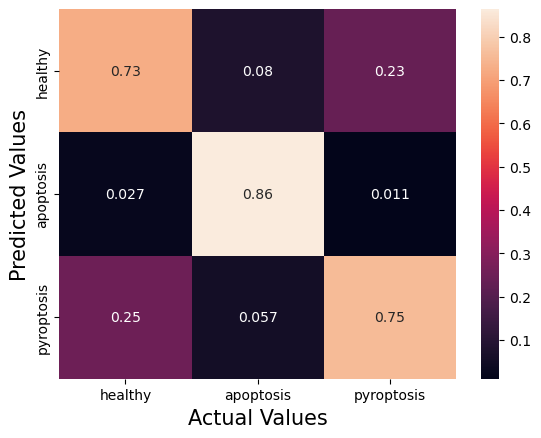

In [77]:
ax = sns.heatmap(confusion_matrix_df, annot=True)

plt.xlabel("Actual Values", size=15)
plt.ylabel("Predicted Values", size=15)
plt.show()

In [78]:
stats_df = output_stats(
    y_pred_list,
    Y_holdout,
    mlp_params,
    test_name=f"{mlp_params.MODEL_NAME}_train",
    model_name=mlp_params.MODEL_NAME,
    title=mlp_params.MODEL_NAME,
    shuffle=mlp_params.SHUFFLE,
)
# make into a dataframe
stats_df = pd.DataFrame.from_dict(stats_df).transpose()
stats_df.reset_index(inplace=True)
stats_df.rename(columns={"index": "label"}, inplace=True)
stats_df = stats_df.melt(id_vars=["label"], var_name="metric", value_name="value")
# if accuracy in row of column 1 then change value of column 2 to accuracy
stats_df.loc[stats_df["label"] == "accuracy", "metric"] = "accuracy"
# create a decoder dictionary from df_labels
df_labels["new_labels"] = df_labels["new_labels"].astype(str)
decoder = df_labels.set_index("new_labels").to_dict()["labels"]
decoder["accuracy"] = "accuracy"
decoder["macro avg"] = "macro avg"
decoder["weighted avg"] = "weighted avg"
stats_df["label"] = stats_df["label"].map(decoder)

              precision    recall  f1-score   support

           0       0.86      0.58      0.69      7048
           1       0.73      0.81      0.77     77041
           2       0.75      0.68      0.71     66812

    accuracy                           0.74    150901
   macro avg       0.78      0.69      0.72    150901
weighted avg       0.74      0.74      0.74    150901



/tmp/ipykernel_728270/3730111117.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels["new_labels"] = df_labels["new_labels"].astype(str)


In [79]:
stats_df["group"] = "holdout"
stats_df["shuffled_data"] = mlp_params.SHUFFLE

model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)
model_stats_df

/tmp/ipykernel_728270/1582550840.py:4: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  model_stats_df = pd.concat([model_stats_df, stats_df], axis=0)


,label,metric,value,group,shuffled_data
0,apoptosis,precision,0.027982,train,False
1,healthy,precision,0.568947,train,False
2,pyroptosis,precision,0.407116,train,False
3,accuracy,accuracy,0.494301,train,False
4,macro avg,precision,0.334682,train,False
...,...,...,...,...,...
19,healthy,support,77041.000000,holdout,False
20,pyroptosis,support,66812.000000,holdout,False
21,accuracy,accuracy,0.741281,holdout,False
22,macro avg,support,150901.000000,holdout,False


In [80]:
# set path for the model confusion matrices
predictions_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
predictions_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{predictions_path}/single_cell_predictions.parquet")
if matrix_file.exists():
    predictions_df_tmp = pd.read_parquet(matrix_file)
    if len(predictions_df_tmp["data_split"].unique()) > 1:
        pass
    elif predictions_df_tmp["data_split"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([predictions_df_tmp, final_predictions_df], axis=0)
        metrics_df.to_parquet(matrix_file, index=False)
else:
    final_predictions_df.to_parquet(matrix_file, index=False)

In [ ]:
# set path for the model confusion matrices
matrix_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
matrix_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
matrix_file = pathlib.Path(f"{matrix_path}/confusion_matrices.csv")
if matrix_file.exists():
    metrics_df = pd.read_csv(matrix_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, data_split_conf_mat_df_all], axis=0)
        metrics_df.to_csv(matrix_file, index=False)
else:
    data_split_conf_mat_df_all.to_csv(matrix_file, index=False)

In [ ]:
# set path for the model training metrics
metrics_path = pathlib.Path(
    f"../../results/{mlp_params.MODEL_TYPE}/{mlp_params.MODEL_NAME}/{mlp_params.CELL_TYPE}"
)
metrics_path.mkdir(parents=True, exist_ok=True)
# check if the model training metrics file exists
metrics_file = pathlib.Path(f"{metrics_path}/training_metrics.csv")
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    if len(metrics_df["shuffled_data"].unique()) > 1:
        pass
    elif metrics_df["shuffled_data"].unique() == mlp_params.SHUFFLE:
        pass
    else:
        metrics_df = pd.concat([metrics_df, model_stats_df], axis=0)
        metrics_df.to_csv(metrics_file, index=False)
else:
    model_stats_df.to_csv(metrics_file, index=False)